<a href="https://colab.research.google.com/github/suruchi1997/yolov7/blob/main/TF_Mobilenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [2]:
# Data Preprocess

_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

68606236/68606236 [==============================] - 2s 0us/step
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [4]:
# Dividing into val and test set
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 21
Number of test batches: 5


In [5]:
#Load data directly from disk
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

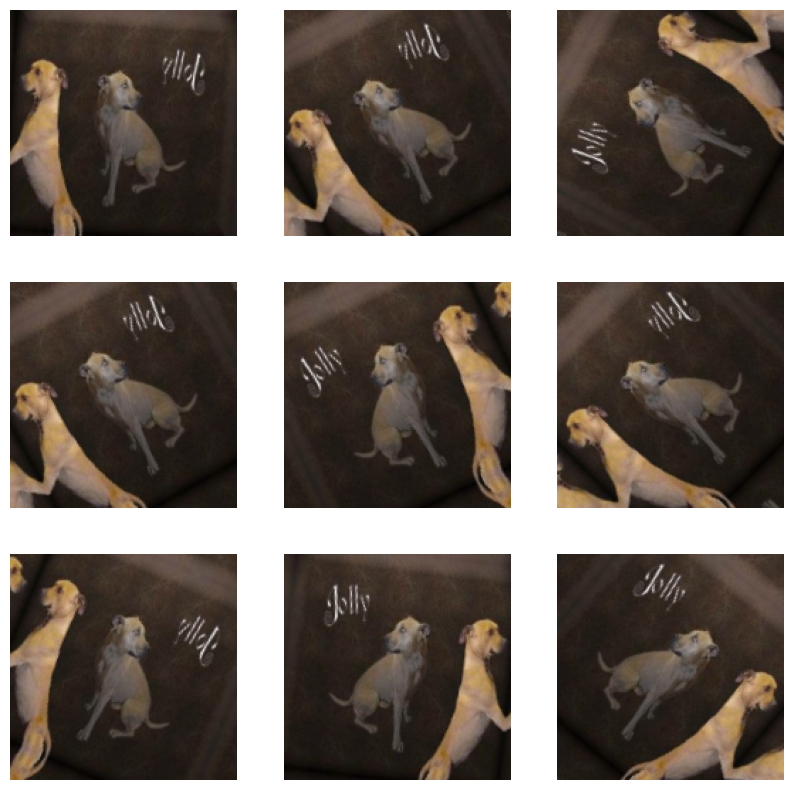

In [6]:
# data augmentation , since dataset is small
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [7]:
# Rescaling the data according to the model we are utilizing 
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [8]:
# Using MobileNet for  feature extraction , include_top=false will not include dense layers for classification
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


9406464/9406464 [==============================] - 1s 0us/step


In [9]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

# feeze convolution layers of base model
base_model.trainable = False

# summarizing base_model
base_model.summary()



(32, 5, 5, 1280)
Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0        

In [10]:
#clasification head

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

#using training = False as model has batchnormalization layer
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

(32, 1280)
(32, 1)


In [11]:
#compile model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [12]:
# trainable variables
len(model.trainable_variables)

#evaluation after 10 epochs
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

21/21 [==============================] - 5s 47ms/step - loss: 0.5718 - accuracy: 0.6852
initial loss: 0.57
initial accuracy: 0.69


In [13]:
# fitting train_dataset
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 9s 66ms/step - loss: 0.5366 - accuracy: 0.6990 - val_loss: 0.3944 - val_accuracy: 0.8164
Epoch 2/10
63/63 [==============================] - 4s 56ms/step - loss: 0.4080 - accuracy: 0.8080 - val_loss: 0.3065 - val_accuracy: 0.8688
Epoch 3/10
63/63 [==============================] - 5s 70ms/step - loss: 0.3492 - accuracy: 0.8370 - val_loss: 0.2518 - val_accuracy: 0.9043
Epoch 4/10
63/63 [==============================] - 4s 57ms/step - loss: 0.3032 - accuracy: 0.8640 - val_loss: 0.2084 - val_accuracy: 0.9198
Epoch 5/10
63/63 [==============================] - 4s 56ms/step - loss: 0.2574 - accuracy: 0.8910 - val_loss: 0.1772 - val_accuracy: 0.9306
Epoch 6/10
63/63 [==============================] - 5s 73ms/step - loss: 0.2548 - accuracy: 0.8905 - val_loss: 0.1658 - val_accuracy: 0.9367
Epoch 7/10
63/63 [==============================] - 4s 55ms/step - loss: 0.2268 - accuracy: 0.9050 - val_loss: 0.1491 - val_accuracy: 0.9414
Epoch 8/10
63

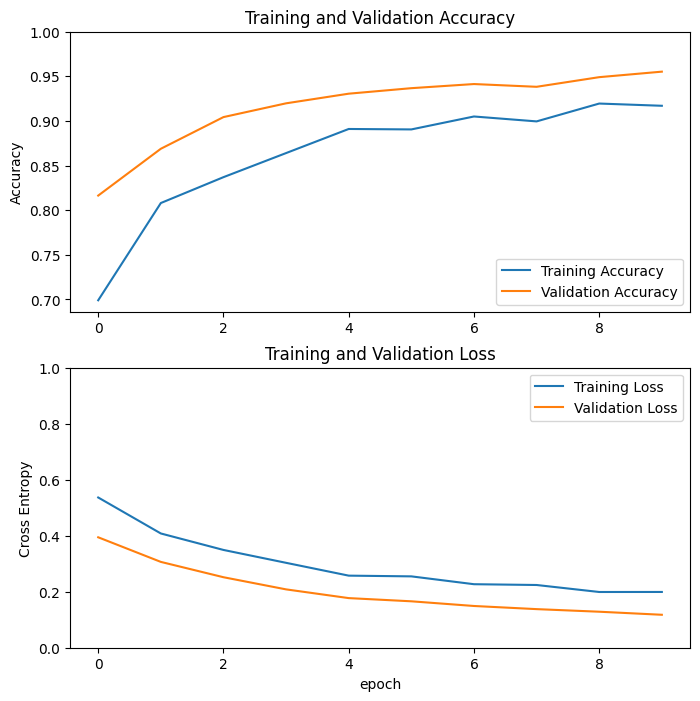

In [14]:
#learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [15]:
#fine tune
#unfreeze top layers
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

#compile model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
# model summary
model.summary()

Number of layers in the base model:  154
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                    

Epoch 10/20
63/63 [==============================] - 16s 76ms/step - loss: 0.1561 - accuracy: 0.9240 - val_loss: 0.0661 - val_accuracy: 0.9769
Epoch 11/20
63/63 [==============================] - 5s 84ms/step - loss: 0.1150 - accuracy: 0.9500 - val_loss: 0.0726 - val_accuracy: 0.9784
Epoch 12/20
63/63 [==============================] - 4s 60ms/step - loss: 0.1103 - accuracy: 0.9555 - val_loss: 0.0670 - val_accuracy: 0.9691
Epoch 13/20
63/63 [==============================] - 4s 60ms/step - loss: 0.0902 - accuracy: 0.9660 - val_loss: 0.0530 - val_accuracy: 0.9799
Epoch 14/20
63/63 [==============================] - 5s 76ms/step - loss: 0.0858 - accuracy: 0.9665 - val_loss: 0.0430 - val_accuracy: 0.9784
Epoch 15/20
63/63 [==============================] - 4s 60ms/step - loss: 0.0873 - accuracy: 0.9645 - val_loss: 0.0460 - val_accuracy: 0.9784
Epoch 16/20
63/63 [==============================] - 4s 60ms/step - loss: 0.0732 - accuracy: 0.9700 - val_loss: 0.0409 - val_accuracy: 0.9861
Epoch

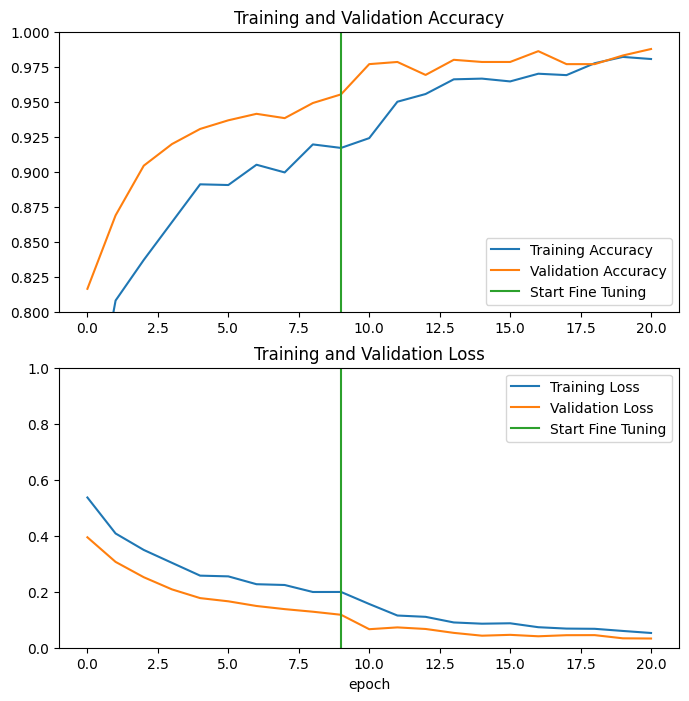

In [16]:
len(model.trainable_variables)

# continue training the model

fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

# compute loss
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
# plot the curves

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()